In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
REPO_NAME = 'sewer-nfl'
import sys, os
cwd = str(os.getcwd())
repo_dir = cwd[:cwd.find(REPO_NAME)+len(REPO_NAME)]
sys.path.insert(0,repo_dir)

In [3]:
import pandas as pd
import nfl_data_py as nflreadr

In [4]:
from warehouse.utilities.elo import calculate_elo_metric

In [5]:
api_data = nflreadr.import_pbp_data(range(2021,2023))

2021 done.
2022 done.
Downcasting floats.


In [6]:
api_data = api_data[api_data['week']<=18]

In [7]:
from warehouse.pipelines.pbp.pbp import player_involvement, player_involved, players_involved

In [8]:
player_involvement_df = player_involvement(pbp_data=api_data)

In [9]:
player_involved(player_involvement_df=player_involvement_df,
                #play_id = 40.0,
                #game_id = '2021_01_ARI_TEN',
                player_id = '00-0032560')

TypeError: player_involved() missing 2 required positional arguments: 'play_id' and 'game_id'

In [10]:
meta_columns = [
    'game_id',
    'old_game_id',
    'season',
    'week',
    'home_team',
    'away_team',
    'posteam',
    'spread_line'
]

play_columns = [
    'play_id',
    'play_type',
    'desc',
    'yards_gained',
    'passer_player_id',
    'receiver_player_id',
    'rusher_player_id',
    'offense_players',
    'defense_players'
]

epa_columns = [
    'epa',
    'air_epa',
    'yac_epa'
]

In [11]:
# Player Id Lookup function
rosters = nflreadr.import_rosters(years=[2020,2022])

In [12]:
r_columns = [
    'season',
    'week',
    'team',
    'position',
    'player_name',
    'player_id'
]
rosters[r_columns]

,season,week,team,position,player_name,player_id
0,2020,17,ARI,DB,Johnathan Joseph,00-0024239
1,2020,17,ARI,DB,Patrick Peterson,00-0027943
2,2020,17,ARI,DB,Prince Amukamara,00-0027957
3,2020,17,ARI,DB,Dre Kirkpatrick,00-0029560
4,2020,17,ARI,DB,Chris Banjo,00-0029747
...,...,...,...,...,...,...
2636,2022,18,WAS,WR,Antonio Gandy-Golden,00-0036340
2637,2022,18,WAS,WR,Dyami Brown,00-0036626
2638,2022,18,WAS,WR,Dax Milne,00-0036671
2639,2022,18,WAS,WR,Jahan Dotson,00-0037741


In [13]:
from scipy.stats import zscore

In [14]:
# Use to reduce outlier positions
position_filter = ['QB','RB','WR','TE']

dataset_cols = meta_columns + [
    'play_id',
    'play_type',
    'yards_gained',
    'rusher_player_id',
    'epa'
]

epa_dataset = api_data[dataset_cols]

mask = (epa_dataset['play_type']=='run')

epa_dataset = epa_dataset.loc[mask].merge(
    rosters[[
        'player_name',
        'position',
        'player_id'
        ]],
    left_on = ['rusher_player_id'],
    right_on = ['player_id'],
    how = 'inner'
).drop_duplicates()

position_mask = (epa_dataset['position'].isin(position_filter))

epa_dataset = epa_dataset[position_mask]

epa_dataset['defteam'] = epa_dataset.apply(lambda x : x['home_team'] if x['away_team']==x['posteam'] else x['away_team'], axis = 1)
# Pre-elo datasets should be at the game / team / player level

order_cols = ['season','week'] # Used in ELO function
off_gb_cols = ['posteam','defteam','position','rusher_player_id','player_name'] # At what level are we AGGREGATING offensive performance
gb_cols_z = ['season','position'] # What is aggregate level for z score
def_gb_cols = ['posteam','defteam','position'] # Matched up against what level on defense to AGGREGATE to
perf_cols = ['epa'] # What are we assessing for ELO

off_epa_dataset = epa_dataset.groupby(order_cols + off_gb_cols)[perf_cols].sum().reset_index()
for col in perf_cols:
    off_epa_dataset[f'z_{col}'] = off_epa_dataset.groupby(order_cols + gb_cols_z)[col].transform(lambda x : zscore(x))
off_epa_dataset.drop(perf_cols, axis = 1, inplace = True)

def_epa_dataset = epa_dataset.groupby(order_cols + def_gb_cols)[perf_cols].sum().reset_index()
for col in perf_cols:
    def_epa_dataset[f'z_{col}'] = def_epa_dataset.groupby(order_cols + gb_cols_z)[col].transform(lambda x : zscore(x))
def_epa_dataset.drop(perf_cols, axis = 1, inplace = True)

# Don't need to use cumulative functions, because this is retroactive and we can use long term averages by position
#  epa_dataset[[f'cum_{col}' for col in perf_cols]] = epa_dataset.groupby(off_gb_cols_cum)[perf_cols].cumsum()
# epa_dataset['cum_n'] = epa_dataset.groupby(off_gb_cols_cum)[perf_cols[0]].cumcount()
# for col in perf_cols:
#     epa_dataset[f'cummean_{col}'] = epa_dataset[f'cum_{col}'] / (epa_dataset['cum_n'] + 1)
# # Calculate standard deviation
# epa_dataset.groupby(off_gb_cols_cum)['yards_gained'].expanding().std()

In [30]:
def_appearance_columns = ['defteam','position']
def_epa_dataset['def_appearance'] = def_epa_dataset.sort_values(order_cols).groupby(def_appearance_columns)['posteam'].cumcount() + 1

off_appearance_columns = ['position','rusher_player_id']
off_epa_dataset['off_appearance'] = off_epa_dataset.sort_values(order_cols).groupby(off_appearance_columns)['defteam'].cumcount() + 1

In [184]:
from warehouse.utilities.elo import calculate_elo_metric

elo_df = calculate_elo_metric(
    input_off_data = off_epa_dataset,
    input_def_data = def_epa_dataset
)

elo_df

,season,week,posteam,defteam,position,rusher_player_id,player_name,z_epa_x,off_appearance,z_epa_y,def_appearance,off_elo,def_elo,off_elo_next,def_elo_next
0,2021,1,ARI,TEN,QB,00-0035228,Kyler Murray,-0.320083,1,-0.304799,1,2000,2000,1996.79917,2003.047992
1,2021,1,ARI,TEN,RB,00-0033553,James Conner,-0.120027,1,1.314033,1,2000,2000,1998.79973,1986.859669
2,2021,1,ARI,TEN,RB,00-0034681,Chase Edmonds,1.566789,1,1.314033,1,2000,1986.859669,2015.78191,1973.814275
3,2021,1,ATL,PHI,QB,00-0026143,Matt Ryan,-0.640594,1,-0.586282,1,2000,2000,1993.594059,2005.862817
4,2021,1,ATL,PHI,RB,00-0030578,Cordarrelle Patterson,2.207344,1,0.736142,1,2000,2000,2022.073437,1992.638578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4487,2022,18,WAS,DAL,RB,00-0032975,Jonathan Williams,-2.008978,12,-1.545616,34,2030.557692,2161.954464,2011.806848,2178.514298
4488,2022,18,WAS,DAL,RB,00-0034578,Reggie Bonnafon,-0.074378,2,-1.545616,34,2000.655488,2178.514298,1999.978228,2195.488469
4489,2022,18,WAS,DAL,RB,00-0036755,Jaret Patterson,-0.082603,15,-1.545616,34,2011.590955,2195.488469,2010.840706,2212.505833
4490,2022,18,WAS,DAL,TE,00-0037168,Armani Rogers,-1.412397,2,-1.412397,3,2013.156982,1976.220206,1998.742359,1990.059382


In [112]:
# Attempt #2: Generate elo dataframe using "most recent" dictionary lookup rather than indexing df every row
off_df = off_epa_dataset
def_df = def_epa_dataset

elo_df = off_df.merge(def_df, 
                      on = order_cols + def_gb_cols,
                      how = 'left')

# Note: Performance may not be equivalent between offense and defense, 
# since levels of aggregation may be different. All that matters is that
# the ELO multiplier is applied equivalently to both adjustments. Also, 
# remember performance will be inverse for defense

elo_df['off_elo'] = None
elo_df['def_elo'] = None
elo_df['off_elo_next'] = None
elo_df['def_elo_next'] = None

caching_dict = {} #Will store most recent results
# Put fewer categories first for better performance
off_lookup_values = ['position','rusher_player_id']
def_lookup_values = ['position','defteam']
elo_base = 2000

def elo_multiplier(off_elo, def_elo, power = 1.1, multiplier = 10):
    return (off_elo / def_elo) ** power * multiplier

elo_df = elo_df.sort_values(by = order_cols)

for index, row in elo_df.iterrows():
    off_elo_val = elo_base
    def_elo_val = elo_base
    # Check if elo is none
    if row['off_elo'] is None:
        off_tup = tuple([row[key] for key in off_lookup_values] + ['off'])
        # Check if tup in keys of caching_dict
        found = off_tup in caching_dict.keys()
        # If it is found in keys, set elo_val to the value
        if found: 
            off_elo_val = caching_dict[off_tup] if not m.isnan(caching_dict[off_tup]) else elo_base
    if row['def_elo'] is None:
        def_tup = tuple([row[key] for key in def_lookup_values] + ['def'])
        # Check if tup in keys of caching_dict
        found = def_tup in caching_dict.keys()
        # If it is found in keys, set elo_val to the value
        if found: 
            def_elo_val = caching_dict[def_tup] if not m.isnan(caching_dict[def_tup]) else elo_base

    # Calculate ELO to update
    off_elo_val_next = elo_multiplier(off_elo_val, def_elo_val) * row['z_epa_x'] + off_elo_val
    def_elo_val_next = -1 * elo_multiplier(def_elo_val, off_elo_val) * row['z_epa_y'] + def_elo_val
    
    elo_df.at[index, 'off_elo'] = off_elo_val
    elo_df.at[index, 'def_elo'] = def_elo_val
    elo_df.at[index, 'off_elo_next'] = off_elo_val_next
    elo_df.at[index, 'def_elo_next'] = def_elo_val_next

    # Store off and defensive values in caching
    caching_dict[off_tup] = off_elo_val_next
    caching_dict[def_tup] = def_elo_val_next

In [158]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 2]

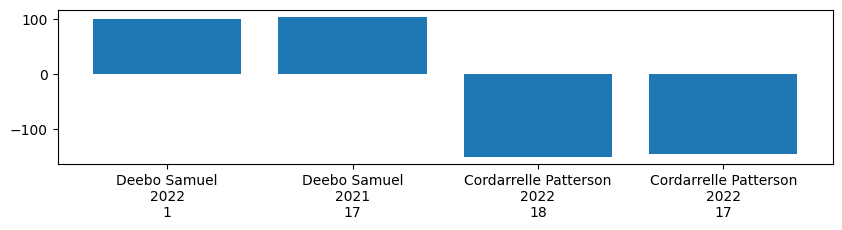

<Figure size 4000x200 with 0 Axes>

In [162]:
pos = 'WR'
asc = True
N = 2

view = elo_df[elo_df['position']==pos].sort_values('off_elo', ascending=asc)[['season','week','player_name','off_elo']].drop_duplicates()
top_rows = view.iloc[-N:]
bottom_rows = view.iloc[:N]

bar = pd.concat([top_rows,bottom_rows])
bar['season'] = bar['season'].astype(str)
bar['week'] = bar['week'].astype(str)
bar['ind'] = bar[['player_name','season', 'week']].agg('\n'.join, axis=1)

plt.bar(bar['ind'], bar['off_elo'] - 2000, align='center')
plt.figure().set_figwidth(40)
plt.show()

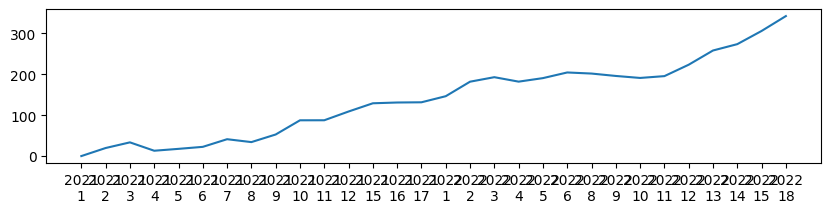

In [180]:
player_name = 'Jalen Hurts'

view = elo_df[elo_df['player_name']==player_name]
view['season'] = view['season'].astype(str)
view['week'] = view['week'].astype(str)
view['ind'] = view[['season', 'week']].agg('\n'.join, axis=1)

plt.plot(view['ind'], view['off_elo'] - 2000)